In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from joblib import Parallel, delayed
import gym

from blackjack_utils import *
from rl_utils import get_average_rewards

%matplotlib inline

plt.rcParams["figure.figsize"] = (20,3)

CONTROL_INTERVAL = 5000

### Часть первая, с блекджеком и стратегиями


1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [2]:
HIGH_NUMBERS = [19, 20, 21]
N = 100_000

env = gym.make('Blackjack-v1')
def simple_strategy(env):
    (player_score, _, _), _ = env.reset()
    done = False
    while not done:
        action = 0 if player_score in HIGH_NUMBERS else 1
        (player_score, _, _), reward, done, _, _ = env.step(action)
      
    return reward



-0.1947


In [3]:
simple_average_reward = np.mean(Parallel(n_jobs=-1)(delayed(simple_strategy)(env) for _ in range(N)))
print(simple_average_reward)

-0.19483


_Стратегия заведомо проигрышная, средний проигрыш - около 0.19_

2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.

In [4]:
NUM_STATES = 23
NUM_ACTIONS = 2

In [6]:
mc_average_rewards = get_average_rewards(env, N, NUM_STATES, NUM_ACTIONS)

100%|███████████████████████████████████████████████████████████████████████| 1000000/1000000 [26:42<00:00, 624.04it/s]


3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

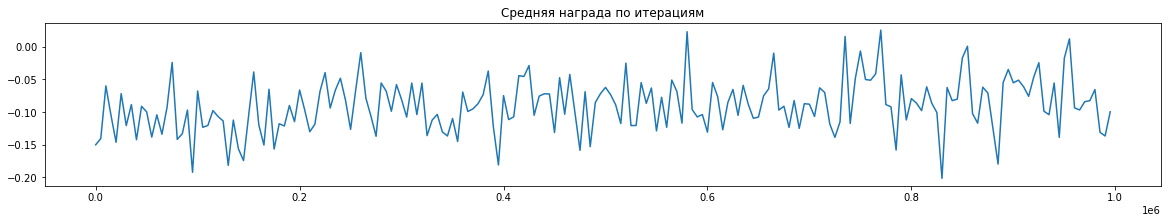

In [7]:
plt.title("Средняя награда по итерациям")
plt.plot([CONTROL_INTERVAL*i for i in range(len(mc_average_rewards))], mc_average_rewards)

In [9]:
print('Средняя награда', np.mean(mc_average_rewards))

Средняя награда -0.09403174


### Часть вторая, удвоенная

In [10]:
class BlackJackWithDouble:
    def __init__(self, env):
        self.env = env
    def reset(self):
        return self.env.reset()
    def step(self, action):
        if action == 2:
            (state, d_state, ace), r, done, info1, info2 =  self.env.step(1)
            while not done:
                (state, d_state, ace), r, done, info1, info2 =  self.env.step(0)
            return (state, d_state, ace), 2 * r, done, info1, info2
        return self.env.step(action)

In [11]:
double_env = BlackJackWithDouble(env)

In [12]:
NUM_STATES = 40
NUM_ACTIONS = 3

In [13]:
double_average_rewards = get_average_rewards(double_env, N, NUM_STATES, NUM_ACTIONS)

100%|███████████████████████████████████████████████████████████████████████| 1000000/1000000 [28:01<00:00, 594.58it/s]


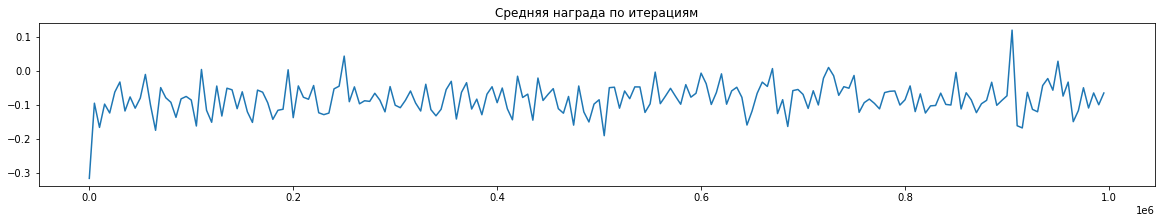

In [14]:
plt.title("Средняя награда по итерациям")
plt.plot([CONTROL_INTERVAL*i for i in range(len(double_average_rewards))], double_average_rewards)

In [16]:
print('Средняя награда', np.mean(double_average_rewards))

Средняя награда -0.08203345


_Стратегия удвоения ставки приводит к увеличению размера среднего выигрыша, но он всё так же остается отрицательным._

### Часть третья, в главной роли — Дастин Хоффман

In [17]:
deck_env = BlackJackWithDeck()

In [18]:
NUM_STATES = 23
NUM_ACTIONS = 2

метод из п.2 без подсчета карт

In [19]:
deck_rewards = get_average_rewards(deck_env, N, NUM_STATES, NUM_ACTIONS)

100%|███████████████████████████████████████████████████████████████████████| 1000000/1000000 [43:09<00:00, 386.24it/s]


In [20]:
print('Средняя награда', np.mean(deck_rewards) + 0.0001)

Средняя награда -0.09227235000000002


С учетом системы Плюс-минус:


In [21]:
NUM_STATES = 23
NUM_ACTIONS = 2
MAX_INDEXES = 75

In [22]:
memorized_deck_rewards = get_average_rewards_with_memorization(deck_env, N, NUM_STATES, NUM_ACTIONS, MAX_INDEXES)

100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [1:05:57<00:00, 252.69it/s]


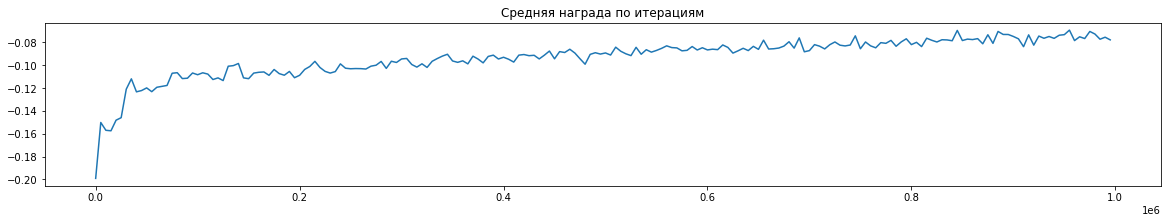

In [23]:
plt.title("Средняя награда по итерациям")
plt.plot([CONTROL_INTERVAL*i for i in range(len(memorized_deck_rewards))], memorized_deck_rewards)

In [25]:
print('Средняя награда', np.mean(memorized_deck_rewards))

Средняя награда -0.0915136847


_Подсчет карт обеспечивает лучше результат, чем без него, но выигрыш всё ещё отрицательный._
